<a href="https://colab.research.google.com/github/the77hnx/works-in-the-univ/blob/main/Mini_Project_ML_for_IOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"akrambelha","key":"3fa0e6738defaf8b34de873ff10cc191"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the dataset from Kaggle
!kaggle datasets download -d ipythonx/mvtec-ad --unzip -p /content

Dataset URL: https://www.kaggle.com/datasets/ipythonx/mvtec-ad
License(s): copyright-authors
100% 4.91G/4.91G [04:26<00:00, 21.1MB/s]
100% 4.91G/4.91G [04:26<00:00, 19.8MB/s]


In [ ]:
import os
import cv2
import numpy as np
import albumentations as A
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNet, EfficientNetB0
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, Callback

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for split_type in ['train', 'test']:
        split_folder = os.path.join(folder, split_type)
        if os.path.isdir(split_folder):
            if split_type == 'train':
                category_folder = os.path.join(split_folder, 'good')
                if os.path.isdir(category_folder):
                    for filename in os.listdir(category_folder):
                        img_path = os.path.join(category_folder, filename)
                        img = cv2.imread(img_path)
                        if img is not None:
                            images.append(img)
                            labels.append('good')
            else:
                for category in os.listdir(split_folder):
                    category_folder = os.path.join(split_folder, category)
                    if os.path.isdir(category_folder):
                        for filename in os.listdir(category_folder):
                            img_path = os.path.join(category_folder, filename)
                            img = cv2.imread(img_path)
                            if img is not None:
                                images.append(img)
                                labels.append(category)
    return images, labels

# Load images
dataset_folder = '/content/carpet'
images, labels = load_images_from_folder(dataset_folder)

In [ ]:
def preprocess_images(images, target_size=(224, 224)):
    processed_images = []
    for img in images:
        img = cv2.resize(img, target_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img / 255.0  # Normalize to [0, 1]
        processed_images.append(img)
    return np.array(processed_images)

# Preprocess images
processed_images = preprocess_images(images)

In [ ]:
processed_images.shape

(397, 224, 224, 3)

In [ ]:
def augment_images(images, labels):
    augmented_images = []
    augmented_labels = []
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Rotate(limit=40, p=0.7),
        A.Blur(blur_limit=3, p=0.5),
    ])
    for img, label in zip(images, labels):
        augmented = transform(image=img)
        augmented_images.append(augmented['image'])
        augmented_labels.append(label)
    return np.array(augmented_images), np.array(augmented_labels)

# Augment images
augmented_images, augmented_labels = augment_images(processed_images, labels)

In [ ]:
augmented_images.shape

(397, 224, 224, 3)

In [ ]:
augmented_labels.shape

(397,)

In [ ]:
def optimize_resolution(images, target_size=(128, 128)):
    optimized_images = []
    for img in images:
        img = cv2.resize(img, target_size)
        optimized_images.append(img)
    return np.array(optimized_images)

# Optimize resolution
optimized_images = optimize_resolution(augmented_images)

In [ ]:
optimized_images.shape

(397, 128, 128, 3)

In [ ]:
def balance_dataset(images, labels):
    X = np.array(images)
    y = np.array(labels)
    oversampler = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = oversampler.fit_resample(X.reshape(X.shape[0], -1), y)
    X_resampled = X_resampled.reshape(-1, X.shape[1], X.shape[2], X.shape[3])
    return X_resampled, y_resampled

# Balance dataset
balanced_images, balanced_labels = balance_dataset(optimized_images, augmented_labels)

In [ ]:
balanced_images.shape

(1848, 128, 128, 3)

In [ ]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(balanced_images, balanced_labels, test_size=0.2, random_state=42)

In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

num_classes = len(label_encoder.classes_)
y_train_categorical = tf.keras.utils.to_categorical(y_train_encoded, num_classes)
y_test_categorical = tf.keras.utils.to_categorical(y_test_encoded, num_classes)

In [ ]:
class StopTrainingAtAccuracy(Callback):
    def __init__(self, target_accuracy):
        super(StopTrainingAtAccuracy, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        # Get the validation accuracy from logs
        val_accuracy = logs.get("val_accuracy")
        if val_accuracy is not None and val_accuracy >= self.target_accuracy:
            print(f"\nStopping training as val_accuracy reached {val_accuracy:.2f}, which is greater than or equal to {self.target_accuracy}.")
            self.model.stop_training = True

In [ ]:
# Target validation accuracy
target_accuracy = 0.96

# Create the custom callback
stop_training_callback = StopTrainingAtAccuracy(target_accuracy)

In [ ]:
# Define the MobileNet model
def create_mobilenet(input_shape, num_classes):
    base_model = MobileNet(input_shape=input_shape, include_top=False, weights='imagenet')
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # تجميد الطبقات الأساسية
    for layer in base_model.layers:
        layer.trainable = False

    return model


    # Model parameters
input_shape = X_train.shape[1:]  # Replace with your data shape
num_classes = y_train_categorical.shape[1]  # Number of classes

# Initialize and compile the model
mobilenet_model = create_mobilenet(input_shape, num_classes)



mobilenet_model.compile(optimizer=Adam(learning_rate=0.001),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20)  # Stop if val_loss doesn't improve for 3 epochs

# Train the model
mobilenet_history = mobilenet_model.fit(
    X_train,
    y_train_categorical,
    epochs=50,
    validation_data=(X_test, y_test_categorical),
    callbacks=[early_stopping, stop_training_callback]
)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 160ms/step - accuracy: 0.3818 - loss: 1.6502 - val_accuracy: 0.7649 - val_loss: 0.8130
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7920 - loss: 0.6606 - val_accuracy: 0.8649 - val_loss: 0.4985
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8934 - loss: 0.3967 - val_accuracy: 0.9108 - val_loss: 0.3627
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9361 - loss: 0.2675 - val_accuracy: 0.9514 - val_loss: 0.1920
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9684 - loss: 0.1664 - val_accuracy: 0.9568 - val_loss: 0.1747
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9862 - loss: 0.1107
Stopping training as val_accuracy reached 0.97, which is greater than or equal to 0.96.
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9862 - loss: 0.1105 - val_accuracy: 0.9703 - val_loss: 0.1263


In [ ]:
# Target validation accuracy
target_accuracy = 0.96

# Create the custom callback
stop_training_callback = StopTrainingAtAccuracy(target_accuracy)

# Define the EfficientNet model
def create_efficientnet(input_shape, num_classes):
    base_model = EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Model parameters
input_shape = X_train.shape[1:]  # Replace with your data shape
num_classes = y_train_categorical.shape[1]  # Number of classes

# Initialize and compile the model
efficientnet_model = create_efficientnet(input_shape, num_classes)
# Updated Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, mode='max')  # Monitor val_accuracy
stop_training_callback = StopTrainingAtAccuracy(target_accuracy=0.96)  # Stop when val_accuracy >= 0.96

# Updated Model Compilation
efficientnet_model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Reduced learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model with both callbacks
efficientnet_history = efficientnet_model.fit(
    X_train,
    y_train_categorical,
    epochs=50,
    validation_data=(X_test, y_test_categorical),
    callbacks=[early_stopping, stop_training_callback],
    batch_size=16  # Reduced batch size
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 127s 563ms/step - accuracy: 0.5352 - loss: 1.3451 - val_accuracy: 0.1649 - val_loss: 2.7404
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 52s 35ms/step - accuracy: 0.9700 - loss: 0.2210 - val_accuracy: 0.1946 - val_loss: 113.4623
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9712 - loss: 0.1095 - val_accuracy: 0.1649 - val_loss: 321.1182
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9822 - loss: 0.0618 - val_accuracy: 0.1541 - val_loss: 445.6284
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9902 - loss: 0.0316 - val_accuracy: 0.1432 - val_loss: 341.3072
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9940 - loss: 0.0204 - val_accuracy: 0.1730 - val_loss: 295.7930
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.9922 - loss: 0.0295 - val_accuracy: 0.2541 - val_loss: 181.5103
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 34m

In [ ]:
# Target validation accuracy
target_accuracy = 0.96

# Create the custom callback
stop_training_callback = StopTrainingAtAccuracy(target_accuracy)

def create_resnet(input_shape, num_classes):
    base_model = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.8)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

resnet_model = create_resnet(input_shape, num_classes)
# Updated Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=50, mode='max')  # Monitor val_accuracy
stop_training_callback = StopTrainingAtAccuracy(target_accuracy=0.96)  # Stop when val_accuracy >= 0.96

# Updated Model Compilation
resnet_model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Reduced learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

resnet_history = resnet_model.fit(
    X_train,
    y_train_categorical,
    epochs=50,
    validation_data=(X_test, y_test_categorical),
    callbacks=[early_stopping, stop_training_callback],
    batch_size=16  # Reduced batch size
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 98s 427ms/step - accuracy: 0.4025 - loss: 1.9329 - val_accuracy: 0.1865 - val_loss: 8.9465
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.9368 - loss: 0.2182 - val_accuracy: 0.1865 - val_loss: 27.0721
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.9842 - loss: 0.0567 - val_accuracy: 0.1865 - val_loss: 54.4540
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.9937 - loss: 0.0342 - val_accuracy: 0.1919 - val_loss: 79.4037
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.9901 - loss: 0.0334 - val_accuracy: 0.1865 - val_loss: 65.0308
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.9885 - loss: 0.0310 - val_accuracy: 0.1865 - val_loss: 139.9331
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.9927 - loss: 0.0200 - val_accuracy: 0.1541 - val_loss: 95.9459
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/

In [ ]:
def evaluate_model(model, X_test, y_test_categorical):
    loss, accuracy = model.evaluate(X_test, y_test_categorical)
    print(f"Test Loss: {loss}")
    print(f"Test Accuracy: {accuracy}")

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test_categorical, axis=1)

    print("Classification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

    print("Confusion Matrix:")
    print(confusion_matrix(y_true_classes, y_pred_classes))

In [ ]:
# Evaluate MobileNet
print("Evaluating MobileNet:")
evaluate_model(mobilenet_model, X_test, y_test_categorical)

Evaluating MobileNet:
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9791 - loss: 0.1113
Test Loss: 0.12630556523799896
Test Accuracy: 0.9702702760696411
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step
Classification Report:
                     precision    recall  f1-score   support

              color       0.99      1.00      0.99        69
                cut       0.97      1.00      0.98        61
               good       1.00      0.82      0.90        62
               hole       1.00      1.00      1.00        68
metal_contamination       0.91      1.00      0.95        53
             thread       0.95      1.00      0.97        57

           accuracy                           0.97       370
          macro avg       0.97      0.97      0.97       370
       weighted avg       0.97      0.97      0.97       370

Confusion Matrix:
[[69  0  0  0  0  0]
 [ 0 61  0  0  0  0]
 [ 1  2 51  0  5  3]
 [ 0  0  0 68  0  0]
 [ 0  0  0  0 53  0]
 [ 0  0  0  0  0 57]]


In [ ]:
# Evaluate EfficientNetB0
print("Evaluating EfficientNetB0:")
evaluate_model(efficientnet_model, X_test, y_test_categorical)

Evaluating EfficientNetB0:
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 447ms/step - accuracy: 0.9991 - loss: 0.0139
Test Loss: 0.029138298705220222
Test Accuracy: 0.9972972869873047
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 555ms/step
Classification Report:
                     precision    recall  f1-score   support

              color       1.00      1.00      1.00        69
                cut       1.00      1.00      1.00        61
               good       1.00      0.98      0.99        62
               hole       1.00      1.00      1.00        68
metal_contamination       0.98      1.00      0.99        53
             thread       1.00      1.00      1.00        57

           accuracy                           1.00       370
          macro avg       1.00      1.00      1.00       370
       weighted avg       1.00      1.00      1.00       370

Confusion Matrix:
[[69  0  0  0  0  0]
 [ 0 61  0  0  0  0]
 [ 0  0 61  0  1  0]
 [ 0  0  0 68  0  0]
 [ 0  0  0  0 53  0]
 [ 0  0  0  0  0 57]]


In [ ]:
# Evaluate ResNet50
print("Evaluating ResNet50:")
evaluate_model(resnet_model, X_test, y_test_categorical)

Evaluating ResNet50:
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 256ms/step - accuracy: 0.9649 - loss: 0.1447
Test Loss: 0.12738525867462158
Test Accuracy: 0.9702702760696411
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 385ms/step
Classification Report:
                     precision    recall  f1-score   support

              color       1.00      1.00      1.00        69
                cut       1.00      1.00      1.00        61
               good       0.87      0.97      0.92        62
               hole       1.00      0.93      0.96        68
metal_contamination       1.00      0.96      0.98        53
             thread       0.96      0.96      0.96        57

           accuracy                           0.97       370
          macro avg       0.97      0.97      0.97       370
       weighted avg       0.97      0.97      0.97       370

Confusion Matrix:
[[69  0  0  0  0  0]
 [ 0 61  0  0  0  0]
 [ 0  0 60  0  0  2]
 [ 0  0  5 63  0  0]
 [ 0  0  2  0 51  0]
 [ 0  0  2  0  0 55]]


In [ ]:
def plot_training_history(history, title):
    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

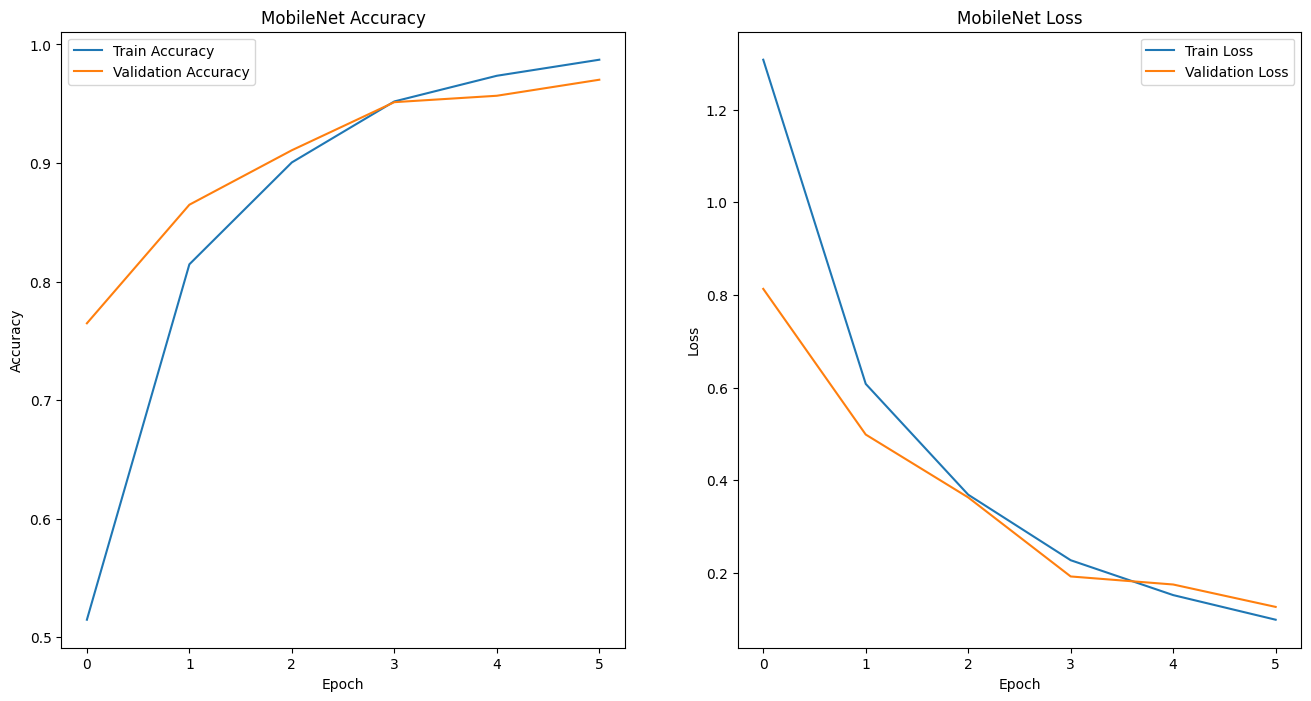

In [ ]:
# Plot MobileNet History
plot_training_history(mobilenet_history, 'MobileNet')

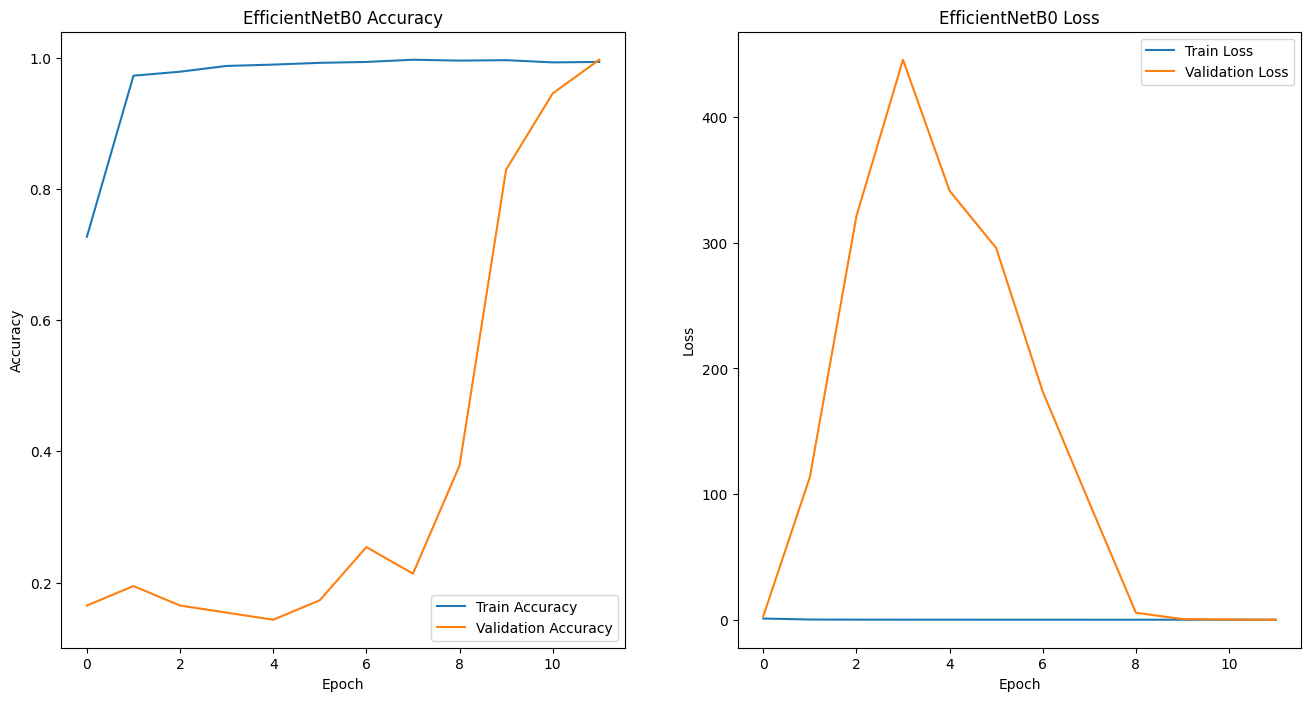

In [ ]:
# Plot EfficientNetB0 History
plot_training_history(efficientnet_history, 'EfficientNetB0')

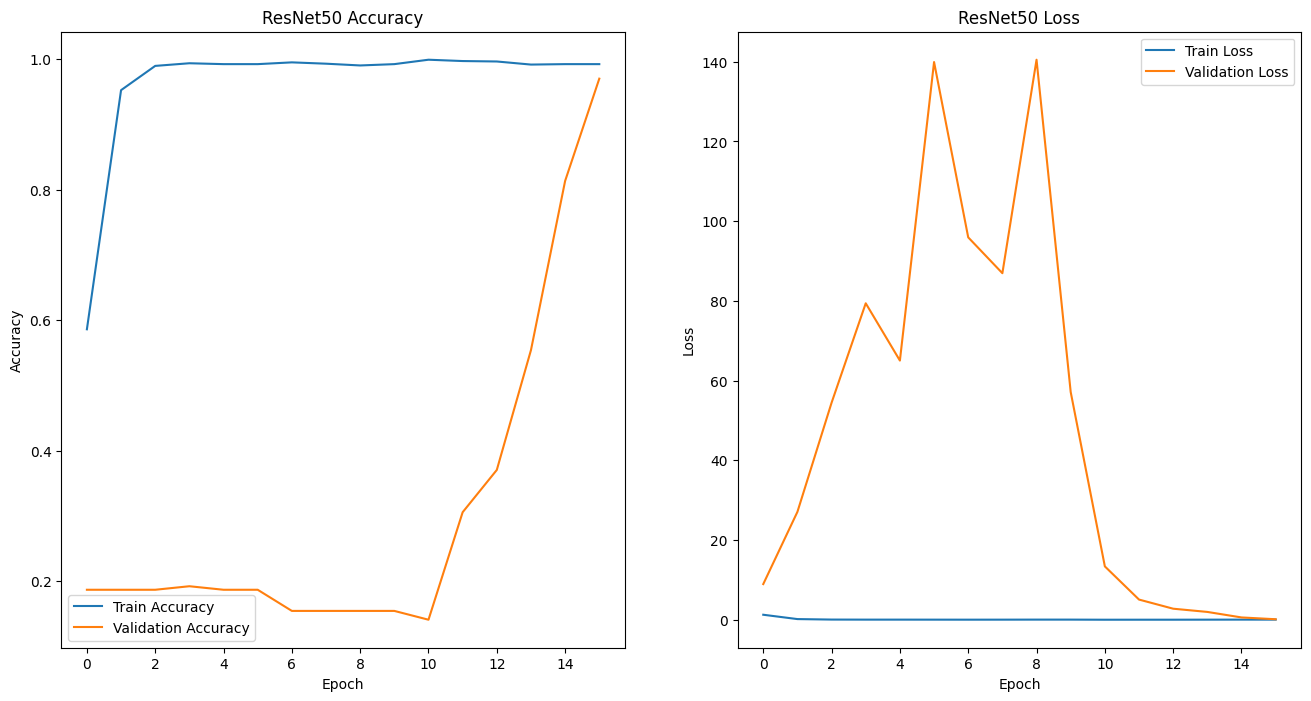

In [ ]:
# Plot ResNet50 History
plot_training_history(resnet_history, 'ResNet50')

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define paths to save models
mobilenet_path = '/content/drive/MyDrive/MobileNet_model.h5'
efficientnet_path = '/content/drive/MyDrive/EfficientNetB0_model.h5'
resnet_path = '/content/drive/MyDrive/ResNet50_model.h5'

# Save models
mobilenet_model.save(mobilenet_path)
efficientnet_model.save(efficientnet_path)
resnet_model.save(resnet_path)

print("Models saved to Google Drive.")

Models saved to Google Drive.


In [ ]:
X_train.shape[1:]

(128, 128, 3)

In [ ]:
y_train_categorical.shape[1]

6